
<div >
    <img src = "../banner/banner_ML_UNLP_1900_200.png" />
</div>



<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/ML_UNLP_Lectures/blob/main/Week06/02_SuperLearner.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# SuperLearners

## Introducción a SuperLearner

SuperLearner es un algoritmo de ensemble learning (aprendizaje conjunto) que combina múltiples algoritmos de predicción para mejorar el rendimiento predictivo. Fue introducido por van der Laan, Polley y Hubbard (2007) como un método para reducir el error de predicción mediante la combinación óptima de varios estimadores.

A continuación, implementaremos SuperLearner manualmente y lo compararemos con la implementación del paquete `SuperLearner` en R.

Comenzamos cargando los paquetes necesarios y configurando una semilla para reproducibilidad.

In [1]:
install.packages("pacman")


The downloaded binary packages are in
	/var/folders/lp/bhbhb__n1_z91_rjfqljxcdc0000gn/T//Rtmp8DGGNp/downloaded_packages


In [2]:
# Cargamos paquetes necesarios
require("pacman")
p_load("tidyverse", "nnls", "data.table", "SuperLearner")

# Semilla para reproducibilidad
set.seed(123)

Loading required package: pacman



Ahora cargamos y preparamos los datos para nuestro análisis. Vamos a utilizar los mismos datos "de juguete" que usamos en el cuaderno de boosting.

In [3]:
# Cargamos los datos
db <- read.csv("https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/SuperLearner_toy.csv")

y <- db$y     # Variable dependiente
x <- db$x     # Variable independiente

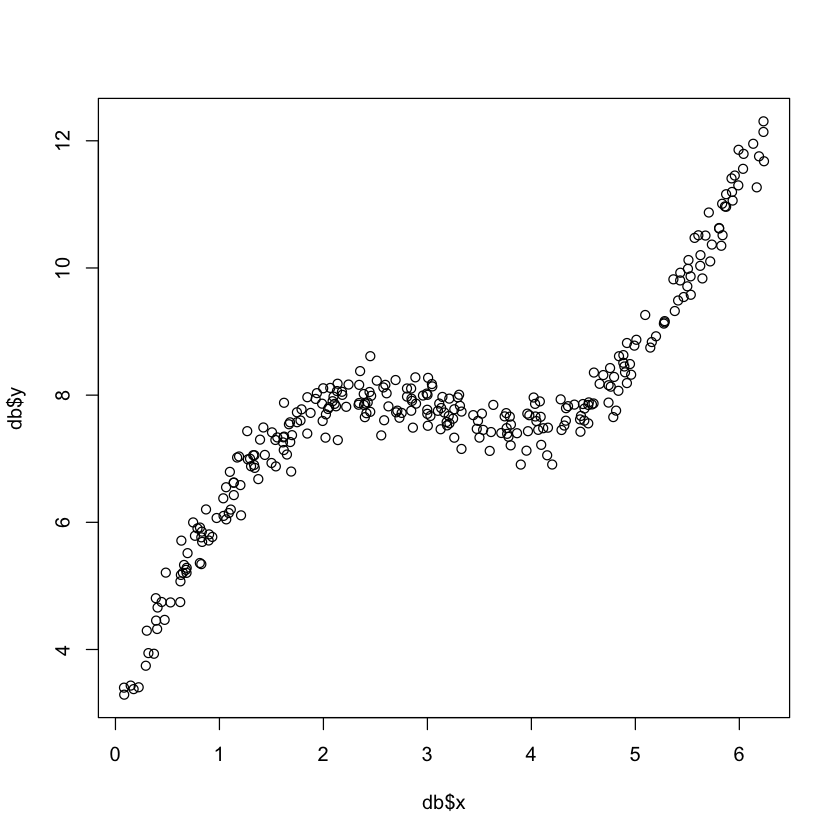

In [4]:
plot(db$x,db$y)

### Creación de Folds para Validación Cruzada

La validación cruzada es fundamental para SuperLearner. Dividimos los datos en k-folds (en este caso, 5) para entrenar y evaluar nuestros modelos.

In [5]:
# Creamos 5 folds para validación cruzada
folds <- 5
index <- split(sample(1:length(y)), rep(1:folds, length = length(y)))

En esta etapa, `index` es una lista donde cada elemento contiene los índices de las observaciones que pertenecen a cada fold. Estos índices se utilizarán tanto en la implementación del paquete como en nuestra implementación manual.

### Implementación de SuperLearner usando el Paquete

Primero, utilizamos el paquete `SuperLearner` para obtener una referencia de los resultados esperados. Comenamos definiendo la biblioteca de algoritmos a utilizar.

Cuáles son las bibliotecas disponibles?

In [6]:
# Review available models.
listWrappers()

All prediction algorithm wrappers in SuperLearner:




 [1] "SL.bartMachine"      "SL.bayesglm"         "SL.biglasso"        
 [4] "SL.caret"            "SL.caret.rpart"      "SL.cforest"         
 [7] "SL.earth"            "SL.gam"              "SL.gbm"             
[10] "SL.glm"              "SL.glm.interaction"  "SL.glmnet"          
[13] "SL.ipredbagg"        "SL.kernelKnn"        "SL.knn"             
[16] "SL.ksvm"             "SL.lda"              "SL.leekasso"        
[19] "SL.lm"               "SL.loess"            "SL.logreg"          
[22] "SL.mean"             "SL.nnet"             "SL.nnls"            
[25] "SL.polymars"         "SL.qda"              "SL.randomForest"    
[28] "SL.ranger"           "SL.ridge"            "SL.rpart"           
[31] "SL.rpartPrune"       "SL.speedglm"         "SL.speedlm"         
[34] "SL.step"             "SL.step.forward"     "SL.step.interaction"
[37] "SL.stepAIC"          "SL.svm"              "SL.template"        
[40] "SL.xgboost"         



All screening algorithm wrappers in SuperLearner:




[1] "All"
[1] "screen.corP"           "screen.corRank"        "screen.glmnet"        
[4] "screen.randomForest"   "screen.SIS"            "screen.template"      
[7] "screen.ttest"          "write.screen.template"


Vamos a usar, `lm` y `rpart`

In [7]:
sl.lib <- c("SL.lm", "SL.rpart")

Ejecutamos SuperLearner con el paquete

In [8]:
set.seed(123)
fitY <- SuperLearner(Y = y, X = data.frame(x = x), 
                     method = "method.NNLS",
                     SL.library = sl.lib,
                     cvControl = list(V = folds, validRows = index))

Loading required namespace: rpart



Aquí, `method.NNLS` se refiere a "Non-Negative Least Squares", que es el método de combinación que asegura que los pesos sean no negativos y sumen 1.

Mostramos los resultados

In [9]:
fitY


Call:  
SuperLearner(Y = y, X = data.frame(x = x), SL.library = sl.lib, method = "method.NNLS",  
    cvControl = list(V = folds, validRows = index)) 


                  Risk      Coef
SL.lm_All    0.7360230 0.1195927
SL.rpart_All 0.2318169 0.8804073

Visualizemos las predicciones

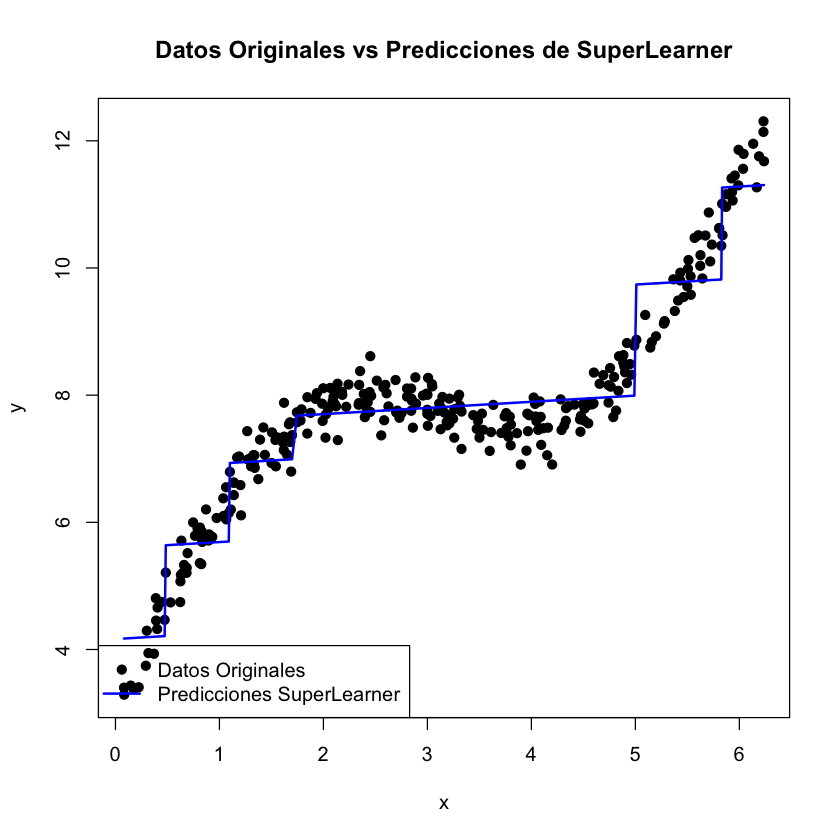

In [10]:
db <- db %>% mutate(yS = predict(fitY, newdata = data.frame(x = x), onlySL = T)$pred)

plot(db$x, db$y, main = "Datos Originales vs Predicciones de SuperLearner",
     xlab = "x", ylab = "y", pch = 19)
lines(db$x[order(db$x)], db$yS[order(db$x)], col = "blue", lwd = 2)
legend("bottomleft", legend = c("Datos Originales", "Predicciones SuperLearner"), 
       col = c("black", "blue"), pch = c(19, NA), lty = c(NA, 1), lwd = c(NA, 2))

### Implementación Manual de SuperLearner

Ahora vamos a implementar SuperLearner manualmente para entender como funciona. 

<div >
<img src = "figs/sl_diagram.png" />
</div>



In [11]:
# 1. Preparamos los datos por fold
folds_data <- list()
for (i in 1:folds) {
  test_indices <- index[[i]]
  train_indices <- setdiff(1:length(y), test_indices)
  
  folds_data[[i]] <- list(
    train = data.frame(x = x[train_indices], y = y[train_indices]),
    test = data.frame(x = x[test_indices], y = y[test_indices]),
    test_indices = test_indices
  )
}


Aquí, para cada fold, separamos los datos en conjunto de entrenamiento y prueba. 


#### Entrenamiento y Predicción para cada Fold

Comenzamos creando una matriz para almacenar las predicciones de cada algoritmo. Este es clave para el punto 3. de la figura

In [12]:
Z <- matrix(NA, nrow = length(y), ncol = length(sl.lib))
colnames(Z) <- sl.lib

In [13]:
Z

SL.lm,SL.rpart
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA
NA,NA


Creamos tambien una Matriz para seguimiento de riesgos por modelo y fold, clave para el punto 4.

In [14]:
fold_risks <- matrix(NA, nrow = folds, ncol = length(sl.lib))
colnames(fold_risks) <- sl.lib

Ahora estamos listos para ejecutar el punto 2, entrenar cada algoritmo

In [15]:
# Entrenamos modelos y obtenemos predicciones
for (i in 1:folds) {
  train_data <- folds_data[[i]]$train
  test_data <- folds_data[[i]]$test
  test_indices <- folds_data[[i]]$test_indices
  
  # SL.lm
  set.seed(123)  # Important for reproducibility
  lm_model <- SL.lm(
    Y = train_data$y,
    X = data.frame(x = train_data$x),
    newX = data.frame(x = test_data$x),
    family = gaussian(),
    obsWeights = rep(1, nrow(train_data))
  )
  Z[test_indices, "SL.lm"] <- lm_model$pred
  fold_risks[i, "SL.lm"] <- mean((test_data$y - lm_model$pred)^2)
  
  # Sl.rpart
  set.seed(123)  # Important for reproducibility
  rpart_model <- SL.rpart(
    Y = train_data$y,
    X = data.frame(x = train_data$x),
    newX = data.frame(x = test_data$x),
      family = gaussian(),
      obsWeights = rep(1, nrow(train_data))
  )
  Z[test_indices, "SL.rpart"] <- rpart_model$pred
  fold_risks[i, "SL.rpart"] <- mean((test_data$y - rpart_model$pred)^2)
}

Que hicimos? 

1. Entrenamos cada algoritmo (lm y rpart) en el conjunto de entrenamiento de cada fold.
2. Hacemos predicciones en el conjunto de prueba correspondiente.
3. Almacenamos las predicciones en la matriz `Z`, donde cada columna corresponde a un algoritmo.
4. Calculamos el riesgo (error cuadrático medio) para cada algoritmo en cada fold.

Antes de seguir calculemos los riesgos generales (MSE) - promedio a través de todos los folds

In [16]:
risks <- colMeans(fold_risks)
risks

SL.lm  SL.rpart 
0.7360230 0.2318169

In [17]:
fitY


Call:  
SuperLearner(Y = y, X = data.frame(x = x), SL.library = sl.lib, method = "method.NNLS",  
    cvControl = list(V = folds, validRows = index)) 


                  Risk      Coef
SL.lm_All    0.7360230 0.1195927
SL.rpart_All 0.2318169 0.8804073

In [18]:
Z

SL.lm,SL.rpart
5.369199,4.357812
5.370751,4.357812
5.420091,4.357812
5.337343,4.041026
5.472900,4.107408
5.534892,4.357812
5.467786,4.003816
5.454375,4.041026
5.524971,4.003816
5.510678,3.874101


#### Cálculo de Pesos Óptimos


En esta etapa final:
1. Utilizamos NNLS para encontrar los pesos óptimos que minimizan el error cuadrático entre las predicciones combinadas y los valores reales.
2. Normalizamos los pesos para asegurar que sumen 1.


In [19]:
# Resolvemos para los pesos óptimos usando NNLS (Non-Negative Least Squares)
weights <- nnls(Z, y)$x
names(weights) <- colnames(Z)


La función `nnls` resuelve el problema de optimización:

$$\min_{\alpha} ||Z\alpha - y||^2 \text{ sujeto a } \alpha \geq 0$$

donde $Z$ es la matriz de predicciones y $y$ son los valores reales.

In [20]:
# Normalizamos los pesos para que sumen 1
weights <- weights / sum(weights)


Finalmente tenemos que

In [21]:
manual_sl_results <- data.frame(
  Risk = risks,
  Coef = weights
)

manual_sl_results

,Risk,Coef
,<dbl>,<dbl>
SL.lm,0.7360230,0.1195927
SL.rpart,0.2318169,0.8804073


Comparamos con los obtenidos por la función SuperLearner

In [22]:
fitY


Call:  
SuperLearner(Y = y, X = data.frame(x = x), SL.library = sl.lib, method = "method.NNLS",  
    cvControl = list(V = folds, validRows = index)) 


                  Risk      Coef
SL.lm_All    0.7360230 0.1195927
SL.rpart_All 0.2318169 0.8804073